### Unweighted

In [54]:
import os

# Define the directory path
directory = r'F:\GitHub\KU-1\Variations\New Data\Measurements'

# Create an empty list to store the file paths
file_paths = []

# Loop through all the files in the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is a .csv file
        if file.endswith('.csv'):
            # If it is, append its path (relative to the directory) to the csv_files list
            file_paths.append(os.path.join(root[len(directory)+1:], file))

# Add the directory path to each file path in the list
file_paths = [os.path.join('New Data', 'Measurements', file).replace('\\', '/') for file in file_paths]


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Function to read and interpolate a .csv file
def interpolate_and_restore_nans(y_values, window):
    not_nan = ~np.isnan(y_values)
    indices = np.arange(len(y_values))
    interpolated_y_values = np.interp(indices, indices[not_nan], y_values[not_nan])
    filtered_y_values = savgol_filter(interpolated_y_values, window, 3)
    filtered_y_values[~not_nan] = np.nan
    return filtered_y_values

# Function to read and interpolate a .csv file
def read_and_interpolate(file_path, x_values):
    df = pd.read_csv(file_path)
    min_x = df['X'].min()
    max_x = df['X'].max()
    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
    f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
    y_values = np.empty_like(x_values)
    y_values[:] = np.nan
    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
    return y_values

# X values to interpolate to (logarithmically spaced from 20 Hz to 20 kHz)
x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

# Read and interpolate all .csv files
data = [read_and_interpolate(file_path, x_values) for file_path in file_paths]

def find_mean_in_range(data, x_min, x_max):
    indices = (x_values >= x_min) & (x_values <= x_max)
    return np.mean(data[indices])

alignment_freq_range = (200, 10000)  # frequency range for alignment

# Calculate the mean values of each dataset in the alignment frequency range
mean_values = [find_mean_in_range(data[i], *alignment_freq_range) for i in range(len(data))]

# Calculate the target mean value as the average of the individual mean values
target_mean = np.mean(mean_values)

# Align datasets to the target mean value
for i in range(len(data)):
    shift = target_mean - mean_values[i]
    data[i] += shift

# Compute the final average of the aligned datasets
average = np.mean(data, axis=0)

# Save the average to a .csv file
average_df = pd.DataFrame({'X': x_values, 'Y': average})
average_df.to_csv('Measurements/community_avg_variations.csv', index=False)


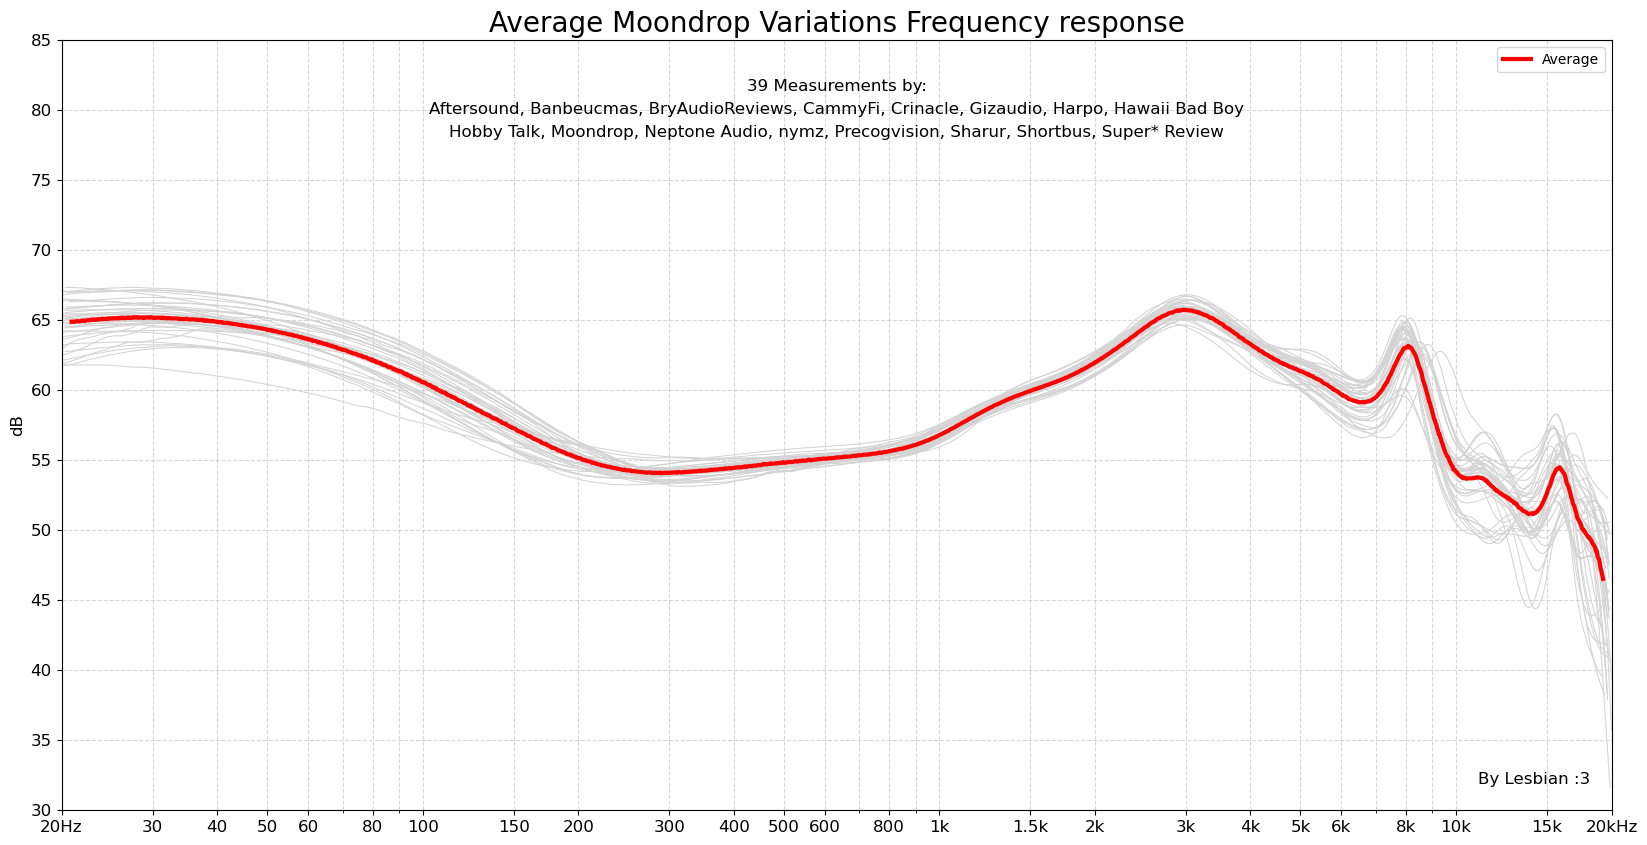

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

plt.figure(figsize=(20, 10))
for y_values in data:
    smoothed_y_values = interpolate_and_restore_nans(y_values, 51)  # Apply Savitzky-Golay filter
    plt.plot(x_values, smoothed_y_values, color='lightgray', linewidth=0.75)
plt.ylim(30, 85)
plt.xlim(20, 20000)
plt.plot(x_values, average, color='red', linewidth=3, label='Average')
plt.xscale('log')

# Customize Y-axis
plt.yticks(np.arange(30, 86, 5), fontsize=12)

# Customize X-axis
x_ticks = np.array([
    20, 30, 40, 50, 60, 80, 100, 150,
    200, 300, 400, 500, 600, 800,
    1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
    10000, 15000, 20000
])
labels = [
    f'{int(x)}Hz' if x == 20
    else f'{int(x)}' if x < 1000
    else f'{x/1000:.1f}k' if x == 1500
    else f'{x//1000:.0f}k' if x != 20000
    else '20kHz' for x in x_ticks
]
plt.xticks(x_ticks, labels=labels, fontsize=12)

# Set labels and title
plt.ylabel('dB', fontsize=12)
plt.title('Average Moondrop Variations Frequency response', fontsize=20)

# Subtitle
plt.text(0.5, 0.95, f'{len(file_paths)} Measurements by:', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
plt.text(0.5, 0.92, 'Aftersound, Banbeucmas, BryAudioReviews, CammyFi, Crinacle, Gizaudio, Harpo, Hawaii Bad Boy', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
plt.text(0.5, 0.89, 'Hobby Talk, Moondrop, Neptone Audio, nymz, Precogvision, Sharur, Shortbus, Super* Review', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')

plt.text(0.95, 0.05, 'By Lesbian :3', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')

# Legend
plt.legend()

# Customize grid
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()


### Weighted-Average

In [57]:
import os

# All Measurement Sources
sources = [
    'aftersound', 'banbeucmas', 'bryaudioreviews', 'cammyfi', 'crinacle',
    'gizaudio', 'harpo', 'hawaiibadboy', 'hobbytalk', 'misc', 'moondrop',
    'neptoneaudio', 'nymz', 'precog', 'sharur', 'shortbus', 'super'
]

# Initialize source_file_paths dictionary with empty lists for each source
source_file_paths = {source: [] for source in sources}

# Iterate over the file paths and categorize them
for file_path in file_paths:
    # Extract the source name from the file path
    source_name = file_path.split('/')[2].split('_')[0].lower()
    
    # If the source name is in the list of sources, append the file path to the corresponding list
    if source_name in sources:
        source_file_paths[source_name].append(file_path)

# Print the measurements in the precog group
print(source_file_paths['precog'])

['New Data/Measurements/precog_S1_L.csv', 'New Data/Measurements/precog_S1_R.csv', 'New Data/Measurements/precog_S2_L.csv', 'New Data/Measurements/precog_S2_R.csv', 'New Data/Measurements/precog_S3_L.csv', 'New Data/Measurements/precog_S3_R.csv']


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def create_average_from_csv_files(file_paths, output_path='Measurements/average_newnewtest.csv'):
    def interpolate_and_restore_nans(y_values, window):
        not_nan = ~np.isnan(y_values)
        indices = np.arange(len(y_values))
        interpolated_y_values = np.interp(indices, indices[not_nan], y_values[not_nan])
        filtered_y_values = savgol_filter(interpolated_y_values, window, 3)
        filtered_y_values[~not_nan] = np.nan
        return filtered_y_values

    def read_and_interpolate(file_path, x_values):
        df = pd.read_csv(file_path)
        min_x = df['X'].min()
        max_x = df['X'].max()
        x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
        f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
        y_values = np.empty_like(x_values)
        y_values[:] = np.nan
        y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
        return y_values

    def find_mean_in_range(data, x_min, x_max):
        indices = (x_values >= x_min) & (x_values <= x_max)
        return np.mean(data[indices])

    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    data = [read_and_interpolate(file_path, x_values) for file_path in file_paths]

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    mean_values = [find_mean_in_range(data[i], *alignment_freq_range) for i in range(len(data))]

    target_mean = np.mean(mean_values)

    for i in range(len(data)):
        shift = target_mean - mean_values[i]
        data[i] += shift

    average = np.mean(data, axis=0)

    average_df = pd.DataFrame({'X': x_values, 'Y': average})
    average_df.to_csv(output_path, index=False)

create_average_from_csv_files(source_file_paths['precog'])

for source in sources:
    create_average_from_csv_files(source_file_paths[source], output_path=f'test/average_{source}.csv')


In [59]:
# Print the categorized file paths

#for source, file_paths in source_file_paths.items():
#    print(source)
#    for file_path in file_paths:
#        print(file_path)


In [60]:
import os

# Define the directory path
directory = r'F:\GitHub\KU-1\Variations\test'

# Create an empty list to store the file paths
weighted_file_paths = []

# Loop through all the files in the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is a .csv file
        if file.endswith('.csv'):
            # If it is, append its path (relative to the directory) to the csv_files list
            weighted_file_paths.append(os.path.join(root[len(directory)+1:], file))

# Add the directory path to each file path in the list
weighted_file_paths = [os.path.join('test', file).replace('\\', '/') for file in weighted_file_paths]


In [61]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Function to read and interpolate a .csv file
def interpolate_and_restore_nans(y_values, window):
    not_nan = ~np.isnan(y_values)
    indices = np.arange(len(y_values))
    interpolated_y_values = np.interp(indices, indices[not_nan], y_values[not_nan])
    filtered_y_values = savgol_filter(interpolated_y_values, window, 3)
    filtered_y_values[~not_nan] = np.nan
    return filtered_y_values

# Function to read and interpolate a .csv file
def read_and_interpolate(file_path, x_values):
    df = pd.read_csv(file_path)
    min_x = df['X'].min()
    max_x = df['X'].max()
    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
    f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
    y_values = np.empty_like(x_values)
    y_values[:] = np.nan
    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
    return y_values

# X values to interpolate to (logarithmically spaced from 20 Hz to 20 kHz)
x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

# Read and interpolate all .csv files
data = [read_and_interpolate(file_path, x_values) for file_path in weighted_file_paths]

def find_mean_in_range(data, x_min, x_max):
    indices = (x_values >= x_min) & (x_values <= x_max)
    return np.mean(data[indices])

alignment_freq_range = (200, 10000)  # frequency range for alignment

# Calculate the mean values of each dataset in the alignment frequency range
mean_values = [find_mean_in_range(data[i], *alignment_freq_range) for i in range(len(data))]

# Calculate the target mean value as the average of the individual mean values
target_mean = np.mean(mean_values)

# Align datasets to the target mean value
for i in range(len(data)):
    shift = target_mean - mean_values[i]
    data[i] += shift

# Compute the final average of the aligned datasets
average = np.mean(data, axis=0)

# Save the average to a .csv file
average_df = pd.DataFrame({'X': x_values, 'Y': average})
average_df.to_csv('Measurements/source-weighted_community_avg_variations.csv', index=False)


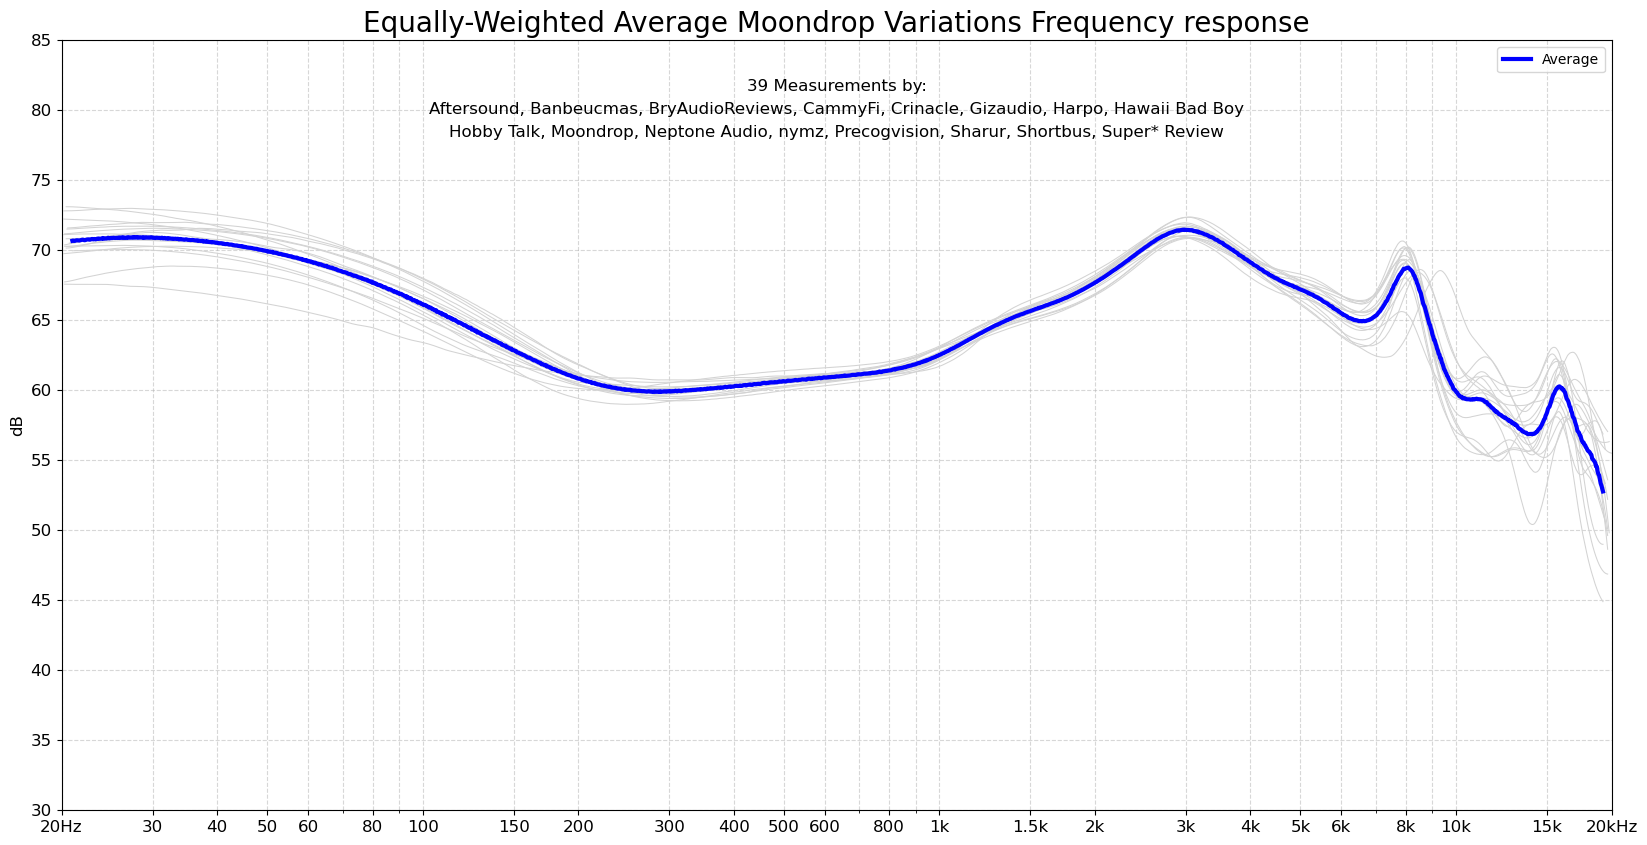

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

plt.figure(figsize=(20, 10))
for y_values in data:
    smoothed_y_values = interpolate_and_restore_nans(y_values, 51)  # Apply Savitzky-Golay filter
    plt.plot(x_values, smoothed_y_values, color='lightgray', linewidth=0.75)
plt.ylim(30, 85)
plt.xlim(20, 20000)
plt.plot(x_values, average, color='blue', linewidth=3, label='Average')
plt.xscale('log')

# Customize Y-axis
plt.yticks(np.arange(30, 86, 5), fontsize=12)

# Customize X-axis
x_ticks = np.array([
    20, 30, 40, 50, 60, 80, 100, 150,
    200, 300, 400, 500, 600, 800,
    1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
    10000, 15000, 20000
])
labels = [
    f'{int(x)}Hz' if x == 20
    else f'{int(x)}' if x < 1000
    else f'{x/1000:.1f}k' if x == 1500
    else f'{x//1000:.0f}k' if x != 20000
    else '20kHz' for x in x_ticks
]
plt.xticks(x_ticks, labels=labels, fontsize=12)

# Set labels and title
plt.ylabel('dB', fontsize=12)
plt.title('Equally-Weighted Average Moondrop Variations Frequency response', fontsize=20)

# Subtitle
plt.text(0.5, 0.95, '39 Measurements by:', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
plt.text(0.5, 0.92, 'Aftersound, Banbeucmas, BryAudioReviews, CammyFi, Crinacle, Gizaudio, Harpo, Hawaii Bad Boy', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
plt.text(0.5, 0.89, 'Hobby Talk, Moondrop, Neptone Audio, nymz, Precogvision, Sharur, Shortbus, Super* Review', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')

# Legend
plt.legend()

# Customize grid
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()
